Please note, We have run this notebook at NimbleBoX and Goolge Colab.

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import datetime
import os
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
# batch_size = 20 #experiment with the batch size

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [4]:
rows = 120
cols = 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# Resizing all the images in specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]  #crop the image

    resized_image = resize(img, (rows,cols)) # resize the image
    return resized_image

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 120
    z = 120
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        
        # write the code for the remaining data points which are left after full batches
        if int(len(t)%batch_size!=0):
            rest_videos_count = int(len(t)%batch_size)
            for folder in range(rest_videos_count): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
# curr_dt_time = datetime.datetime.now()

# train_path = '/content/drive/MyDrive/Project_data/train'
# val_path = '/content/drive/MyDrive/Project_data/val'


# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 20 # choose the number of epochs
# print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


### Model 1: Conv3D
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
frame = 20
rows = 120
cols = 120
num_of_channel = 3
num_of_classes = 5

#write your model here
model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", activation = "relu" , input_shape = (frame, rows, cols, num_of_channel)))
model.add(BatchNormalization())

#HL1
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#HL2
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#HL3
model.add(Conv3D(256, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Fully connected
model.add(Flatten())
model.add(Dense(512,  activation = "relu"))

#output layer
model.add(Dense(num_of_classes, activation = "softmax"))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = "adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 120, 120, 64)  55360     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 120, 120, 64)  256      
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 64)   0         
 )                                                               
                                                        

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 41.5173 - categorical_accuracy: 0.4397  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 105.87888, saving model to model_init_2022-02-0807_26_14.050993/model-00001-41.51729-0.43971-105.87888-0.17000.h5
34/34 [==============================] - 5257s 159s/step - loss: 41.5173 - categorical_accuracy: 0.4397 - val_loss: 105.8789 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 6.0056 - categorical_accuracy: 0.6206
Epoch 00002: val_loss improved from 105.87888 to 36.47105, saving model to model_init_2022-02-0807_26_14.050993/model-00002-6.00562-0.62059-36.47105-0.32000.h5
34/34 [==============================] - 147s 4s/step - loss: 6.0056 - categorical_accuracy: 0.6206 - val_loss: 36.4710 - val_categorical_accuracy:

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

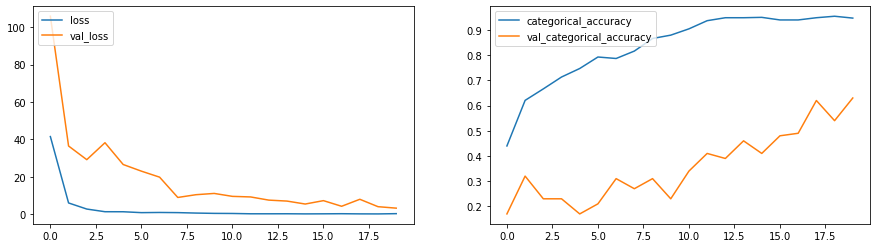

In [ ]:
plot(history)

In [ ]:
model_df = pd.DataFrame()

def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Val Accuracy" : val_accuracy * 100,
                   "Val Loss" : val_loss * 100}

    df = pd.DataFrame([model_dic])
    return df
    

df1 = model_result("Model 1: Conv3D",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

        Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  Model 1: Conv3D        94.70588   28.366187          63.0  322.626042


###  Model 2: With "SGD" Optimizer & L2 Regularization

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Bidirectional,LSTM, SimpleRNN, GRU,TimeDistributed
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (frame, rows, cols, num_of_channel)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(num_of_classes, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_4 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_5 (Batc  (None, 10, 60, 60, 32)   128       
 hNormalization)                                                 
                                                      

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 7.4364 - categorical_accuracy: 0.3368Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 6.47735, saving model to model_init_2022-02-0807_26_14.050993/model-00001-7.43638-0.33676-6.47735-0.19000.h5
34/34 [==============================] - 140s 4s/step - loss: 7.4364 - categorical_accuracy: 0.3368 - val_loss: 6.4774 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 6.0597 - categorical_accuracy: 0.4426
Epoch 00002: val_loss did not improve from 6.47735
34/34 [==============================] - 141s 4s/step - loss: 6.0597 - categorical_accuracy: 0.4426 - val_loss: 6.8121 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 5.8751 - categorical_accuracy: 0.51

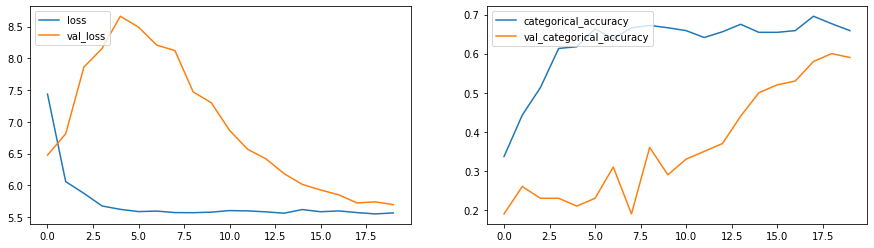

In [ ]:
plot(history)

In [ ]:
df1 = model_result('Model 2: With "SGD" Optimizer & L2 Regularization ',history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  ...    Val Loss
0                                    Model 1: Conv3D  ...  322.626042
0  Model 2: With "SGD" Optimizer & L2 Regularizat...  ...  569.701672

[2 rows x 5 columns]


In [ ]:
pd.set_option("display.max_rows",200)
pd.set_option("display.max_columns",200)

### Model 3 : With Filter (2,2,2) &  HyperParamaters

In [ ]:
model = Sequential()


model.add(Conv3D(16, kernel_size=(2,2,2), padding='same', activation='relu',input_shape = (frame, rows, cols, num_of_channel
)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(num_of_classes, activation = 'softmax'))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  400       
                                                                 
 batch_normalization_8 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 batch_normalization_9 (Batc  (None, 10, 60, 60, 32)   128       
 hNormalization)                                                 
                                                      

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 14.6940 - categorical_accuracy: 0.3941Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 13.93488, saving model to model_init_2022-02-0807_26_14.050993/model-00001-14.69398-0.39412-13.93488-0.16000.h5
34/34 [==============================] - 146s 4s/step - loss: 14.6940 - categorical_accuracy: 0.3941 - val_loss: 13.9349 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 7.9305 - categorical_accuracy: 0.5338
Epoch 00002: val_loss improved from 13.93488 to 12.55084, saving model to model_init_2022-02-0807_26_14.050993/model-00002-7.93053-0.53382-12.55084-0.16000.h5
34/34 [==============================] - 141s 4s/step - loss: 7.9305 - categorical_accuracy: 0.5338 - val_loss: 12.5508 - val_categorical_accuracy: 0.1600 -

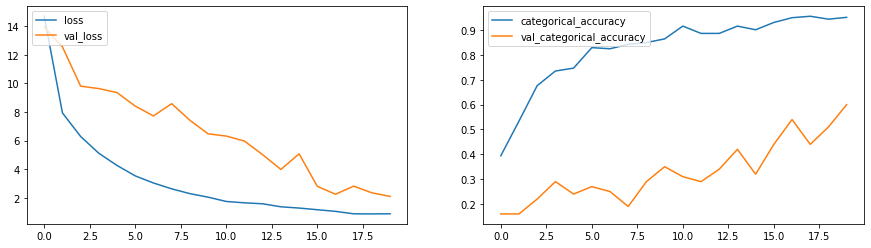

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 3 : With Filter (2,2,2) &  HyperParamaters",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  


###  Model 4 : Hidden Layer

In [ ]:
# Adding more layer to the architecture 

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (frame, rows, cols, num_of_channel
)))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
## h1,2
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h3,4
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())


model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h5,6
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_13 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                                
                                                      

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:

# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 7.8028 - categorical_accuracy: 0.3441Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 6.50825, saving model to model_init_2022-02-0807_26_14.050993/model-00001-7.80278-0.34412-6.50825-0.25000.h5
34/34 [==============================] - 149s 4s/step - loss: 7.8028 - categorical_accuracy: 0.3441 - val_loss: 6.5082 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 6.0078 - categorical_accuracy: 0.4971
Epoch 00002: val_loss improved from 6.50825 to 6.44494, saving model to model_init_2022-02-0807_26_14.050993/model-00002-6.00784-0.49706-6.44494-0.32000.h5
34/34 [==============================] - 141s 4s/step - loss: 6.0078 - categorical_accuracy: 0.4971 - val_loss: 6.4449 - val_categorical_accuracy: 0.3200 - lr: 0.010

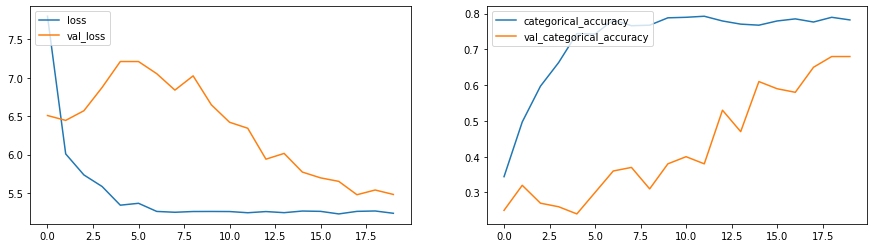

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 4: Hidden Layer",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  


### Model 5: CNN + SimpleRNN

In [ ]:
input_shape = (frame, rows, cols, num_of_channel)

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5877 - categorical_accuracy: 0.3691Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.92883, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.58771-0.36912-1.92883-0.18000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.5877 - categorical_accuracy: 0.3691 - val_loss: 1.9288 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1321 - categorical_accuracy: 0.5441
Epoch 00002: val_loss did not improve from 1.92883
34/34 [==============================] - 144s 4s/step - loss: 1.1321 - categorical_accuracy: 0.5441 - val_loss: 2.0724 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8874 - categorical_accuracy: 0.63

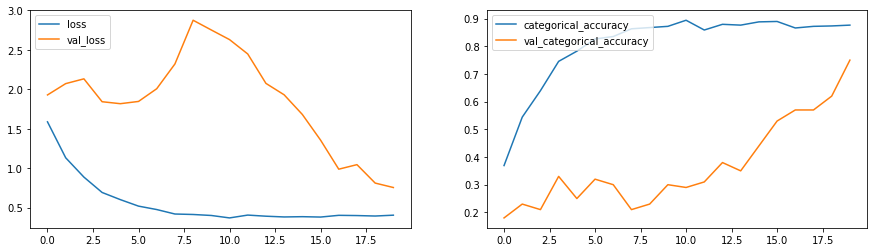

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 5: CNN + SimpleRNN",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  
0   40.465739     75.000000   75.531858  


### Model 6: CNN + SimpleRNN Network( dropout )

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))


model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))


model.add(SimpleRNN(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 120, 120, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 60, 60, 64)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6423 - categorical_accuracy: 0.3441Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.80122, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.64232-0.34412-1.80122-0.22000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.6423 - categorical_accuracy: 0.3441 - val_loss: 1.8012 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1778 - categorical_accuracy: 0.5000
Epoch 00002: val_loss did not improve from 1.80122
34/34 [==============================] - 143s 4s/step - loss: 1.1778 - categorical_accuracy: 0.5000 - val_loss: 1.8708 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9113 - categorical_accuracy: 0.62

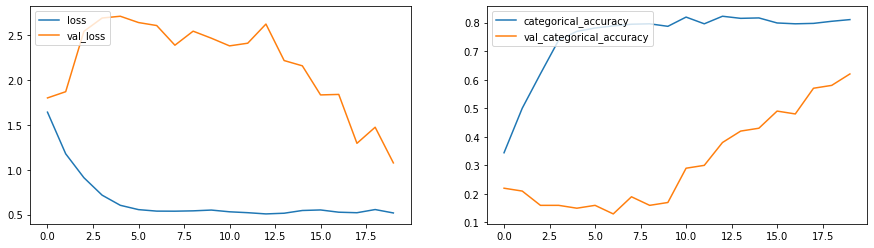

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 6: CNN + SimpleRNN Network(more cells & dropout )",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  
0   40.465739     75.000000   75.531858  
0   51.798290     62.000000  107.647264  


###  Model 7 : CNN + GRU 

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(256))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 60, 60, 32)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4112 - categorical_accuracy: 0.4397Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.40950, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.41121-0.43971-2.40950-0.24000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.4112 - categorical_accuracy: 0.4397 - val_loss: 2.4095 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9778 - categorical_accuracy: 0.6162
Epoch 00002: val_loss improved from 2.40950 to 2.23967, saving model to model_init_2022-02-0807_26_14.050993/model-00002-0.97782-0.61618-2.23967-0.20000.h5
34/34 [==============================] - 147s 4s/step - loss: 0.9778 - categorical_accuracy: 0.6162 - val_loss: 2.2397 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.787

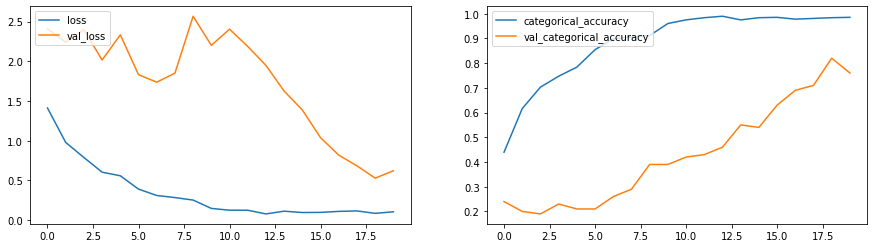

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 7 : CNN + GRU", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  
0   40.465739     75.000000   75.531858  
0   51.798290     62.000000  107.647264  
0   10.427429     75.999999   62.072831  


###  Model 8 : CNN + GRU( more Hidden Layer & Dropout)

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Flatten()))


model.add(GRU(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 20, 120, 120, 64)  1792     
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 20, 120, 120, 64)  256      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 20, 60, 60, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 20, 60, 60, 64)   36928     
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 20, 60, 60, 64)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7414 - categorical_accuracy: 0.3338Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.72028, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.74135-0.33382-2.72028-0.24000.h5
34/34 [==============================] - 144s 4s/step - loss: 1.7414 - categorical_accuracy: 0.3338 - val_loss: 2.7203 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3290 - categorical_accuracy: 0.4441
Epoch 00002: val_loss did not improve from 2.72028
34/34 [==============================] - 141s 4s/step - loss: 1.3290 - categorical_accuracy: 0.4441 - val_loss: 3.4916 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1397 - categorical_accuracy: 0.5382
Epoch 00003: val_loss did not improve from 2.72028

Epoch 00003: ReduceL

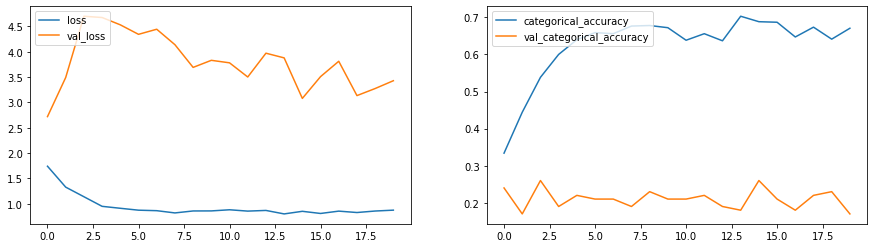

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 8 : CNN + GRU( more Hidden Layer & Dropout)",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   
0  Model 8 : CNN + GRU( more Hidden Layer & Dropout)       67.058825   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  
0   40.465739     75.000000   75.531858  
0   51.798290     62.000000  107.647264  
0   10.427429     75.999999   62.072831  
0   87.482840  

###  Model 9: CNN + LSTM 

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 20, 60, 60, 32)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3828 - categorical_accuracy: 0.4088Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.64417, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.38277-0.40882-1.64417-0.21000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.3828 - categorical_accuracy: 0.4088 - val_loss: 1.6442 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0625 - categorical_accuracy: 0.5926
Epoch 00002: val_loss did not improve from 1.64417
34/34 [==============================] - 138s 4s/step - loss: 1.0625 - categorical_accuracy: 0.5926 - val_loss: 1.7417 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9330 - categorical_accuracy: 0.6338
Epoch 00003: val_loss did not improve from 1.64417

Epoch 00003: ReduceL

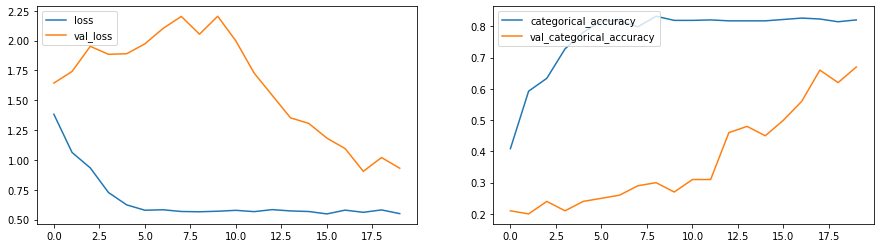

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 9: CNN + LSTM ",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   
0  Model 8 : CNN + GRU( more Hidden Layer & Dropout)       67.058825   
0                               Model 9: CNN + LSTM        82.058823   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550  
0   40.465739     75.000000   75.531858  
0   51.798290     62.000000

### Model 10: CNN + LSTM Network(Removed Hidden Layer, Added Dropout)

In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))


model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(512))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_68 (TimeDi  (None, 20, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 20, 120, 120, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 20, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 20, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 20, 60, 60, 64)  

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5551 - categorical_accuracy: 0.3088Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.85523, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.55506-0.30882-1.85523-0.20000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.5551 - categorical_accuracy: 0.3088 - val_loss: 1.8552 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1467 - categorical_accuracy: 0.5221
Epoch 00002: val_loss did not improve from 1.85523
34/34 [==============================] - 139s 4s/step - loss: 1.1467 - categorical_accuracy: 0.5221 - val_loss: 1.8828 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9443 - categorical_accuracy: 0.6191
Epoch 00003: val_loss did not improve from 1.85523

Epoch 00003: ReduceL

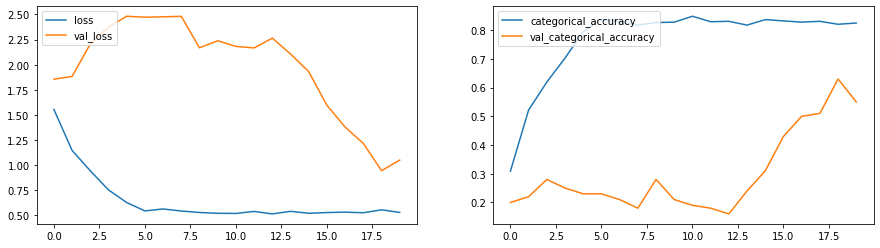

In [ ]:
plot(history)

In [ ]:
df1 = model_result( " Model 10: CNN + LSTM Network(Removed Hidden Layer, Added Dropout)", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   
0  Model 8 : CNN + GRU( more Hidden Layer & Dropout)       67.058825   
0                               Model 9: CNN + LSTM        82.058823   
0   Model 10: CNN + LSTM Network(Removed Hidden L...       82.499999   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.322646     60.000002  208.811498  
0  523.367500     68.000001  547.912550

### Model 11 : CONV3D(More Neuron, Optimizer Adam, Added dropout )

In [ ]:

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(5, activation = 'softmax'))

optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_43 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_44 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                                
                                                     

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 15.3361 - categorical_accuracy: 0.3044Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 11.71244, saving model to model_init_2022-02-0807_26_14.050993/model-00001-15.33614-0.30441-11.71244-0.23000.h5
34/34 [==============================] - 144s 4s/step - loss: 15.3361 - categorical_accuracy: 0.3044 - val_loss: 11.7124 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 10.8860 - categorical_accuracy: 0.4279
Epoch 00002: val_loss did not improve from 11.71244
34/34 [==============================] - 138s 4s/step - loss: 10.8860 - categorical_accuracy: 0.4279 - val_loss: 13.3734 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 9.2363 - categorical_accu

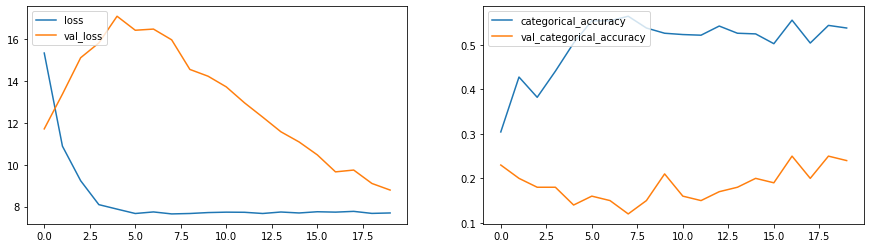

In [ ]:
plot(history)

In [ ]:
df1 = model_result(" Model 11 : conv3d(More Neuron, Optimizer Adam, Added dropout )", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   
0  Model 8 : CNN + GRU( more Hidden Layer & Dropout)       67.058825   
0                               Model 9: CNN + LSTM        82.058823   
0   Model 10: CNN + LSTM Network(Removed Hidden L...       82.499999   
0   Model 11 : conv3d(More Neuron, Optimizer Adam...       53.823531   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.000000  322.626042  
0  556.689978     58.999997  569.701672  
0   87.32

### Model 12 : CON3D(Optimizer SGD)

In [ ]:
#Let's try 'sgd' as optimizer on same architecture with 20 epochs

model = Sequential()


model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dropout(0.50))



model.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_47 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_48 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                                
                                                     

In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 13.1952 - categorical_accuracy: 0.3574Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 11.25053, saving model to model_init_2022-02-0807_26_14.050993/model-00001-13.19522-0.35735-11.25053-0.26000.h5
34/34 [==============================] - 144s 4s/step - loss: 13.1952 - categorical_accuracy: 0.3574 - val_loss: 11.2505 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 10.3775 - categorical_accuracy: 0.5515
Epoch 00002: val_loss did not improve from 11.25053
34/34 [==============================] - 138s 4s/step - loss: 10.3775 - categorical_accuracy: 0.5515 - val_loss: 11.6614 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 10.1170 - categorical_accuracy: 0.6265
Epoch 00003: val_loss did not improve from 11.25053

Epoch 00

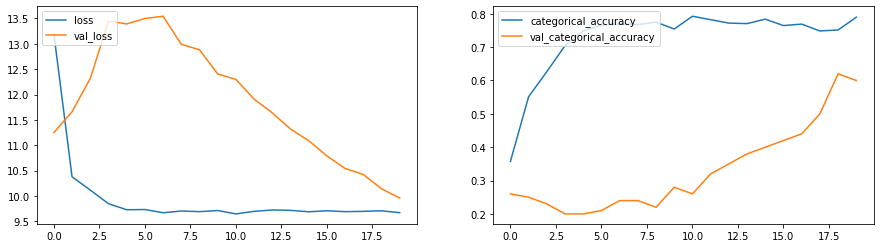

In [ ]:
plot(history)

In [ ]:
df1 = model_result("Model 12 : CON3D(Optimizer SGD)", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_df = pd.concat([model_df,df1])
print(model_df.head(20))

                                          Model Name  Model Accuracy  \
0                                    Model 1: Conv3D       94.705880   
0  Model 2: With "SGD" Optimizer & L2 Regularizat...       65.882355   
0   Model 3 : With Filter (2,2,2) &  HyperParamaters       95.147061   
0                              Model 4: Hidden Layer       78.235292   
0                           Model 5: CNN + SimpleRNN       87.647057   
0  Model 6: CNN + SimpleRNN Network(more cells & ...       81.029409   
0                                Model 7 : CNN + GRU       98.529410   
0  Model 8 : CNN + GRU( more Hidden Layer & Dropout)       67.058825   
0                               Model 9: CNN + LSTM        82.058823   
0   Model 10: CNN + LSTM Network(Removed Hidden L...       82.499999   
0   Model 11 : conv3d(More Neuron, Optimizer Adam...       53.823531   
0                    Model 12 : CON3D(Optimizer SGD)       78.970587   

   Model Loss  Val Accuracy    Val Loss  
0   28.366187     63.

### Model 13: ConvLSTM2D

In [ ]:

from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeDi  (None, 20, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_51 (Bat  (None, 20, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_79 (TimeDi  (None, 20, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_52 (Bat  (None, 20, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


In [ ]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3934 - categorical_accuracy: 0.3662Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.55408, saving model to model_init_2022-02-0807_26_14.050993/model-00001-1.39341-0.36618-2.55408-0.23000.h5
34/34 [==============================] - 152s 5s/step - loss: 1.3934 - categorical_accuracy: 0.3662 - val_loss: 2.5541 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1665 - categorical_accuracy: 0.4412
Epoch 00002: val_loss improved from 2.55408 to 2.19246, saving model to model_init_2022-02-0807_26_14.050993/model-00002-1.16646-0.44118-2.19246-0.14000.h5
34/34 [==============================] - 149s 5s/step - loss: 1.1665 - categorical_accuracy: 0.4412 - val_loss: 2.1925 - val_categorical_accuracy: 0.1400 - lr: 0.010

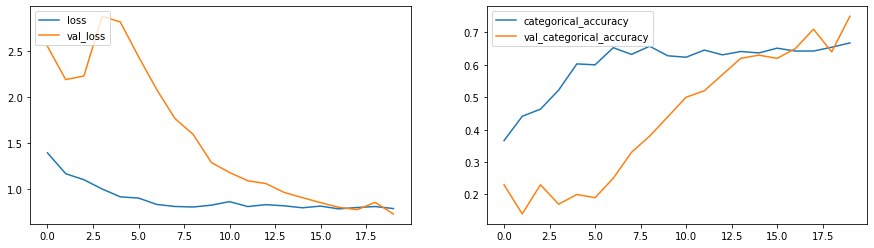

In [ ]:
plot(history)

In [ ]:
# df1 = model_result("Model 13: ConvLSTM2D", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

# model_df = pd.concat([model_df,df1])
# print(model_df.head(20))

### Final Model

### Model 14: ConvLSTM2D(with Batch Size 32 & Epoch 50)

In [8]:
batch_size =32 #experiment with the batch size
num_epochs = 50 # choose the number of epochs

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Bidirectional,LSTM, SimpleRNN, GRU,TimeDistributed
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

frame = 20
rows = 120
cols = 120
num_of_channel = 3
num_of_classes = 5

input_shape = (frame, rows, cols, num_of_channel)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 118, 118, 8)   224       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 118, 118, 8)   32        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 116, 116, 16)  1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 116, 116, 16)  64        
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 114, 114, 8)       6944      
_________________________________________________________________
batch_normalization_2 (Batch (None, 114, 114, 8)       32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 114, 114, 64)     

In [12]:
# Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

# The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  21
Val Epoch value:  4


In [13]:
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 166s 8s/step - loss: 1.4837 - categorical_accuracy: 0.3162 - val_loss: 1.8826 - val_categorical_accuracy: 0.2266

Epoch 00001: val_loss improved from inf to 1.88256, saving model to model_init_2022-02-0904_10_59.618196/model-00001-1.41842-0.36161-1.88256-0.22656.h5
Epoch 2/50
21/21 [==============================] - 93s 5s/step - loss: 1.0691 - categorical_accuracy: 0.4672 - val_loss: 1.9334 - val_categorical_accuracy: 0.2109

Epoch 00002: val_loss did not improve from 1.88256
Epoch 3/50
21/21 [==============================] - 92s 5s/step - loss: 0.9988 - categorical_accuracy: 0.5524 - val_loss: 2.2137 - val_categorical_accuracy: 0.1094

Epoch 00003: val_loss did not improve from 1.88256

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/50
21/21 [==============================] - 95s 5s/step - loss: 0.8777 - categorical_accuracy: 0.6105 - val_l

In [14]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

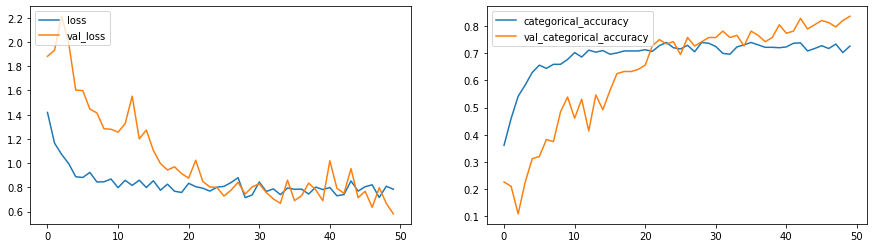

In [15]:
plot(history)

In [ ]:
# df1 = model_result("Model 14 : ConvLSTM2D(with Batch Size 32 & Epoch 50)", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

# model_df = pd.concat([model_df,df1])
# print(model_df.head(20))

In [ ]:
# !pip install pyyaml h5py

In [16]:
model.save("saved_final_model.h5")

In [17]:
model_new=tf.keras.models.load_model("saved_final_model.h5")
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 118, 118, 8)   224       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 118, 118, 8)   32        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 116, 116, 16)  1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 116, 116, 16)  64        
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 114, 114, 8)       6944      
_________________________________________________________________
batch_normalization_2 (Batch (None, 114, 114, 8)       32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 114, 114, 64)     